# Football Match Predictor - Inference

## Library Imports

In [15]:
# Add all the library imports required
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sqlalchemy import create_engine
import json

import data_cleaning
import feature_engineering

import joblib

from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
scores_df = data_cleaning.import_leagues(original_dataset = False, years=[2022, 2023], to_predict=True)
scores_df = data_cleaning.tweak_scores_df(scores_df)
scores_df = data_cleaning.create_match_id_col_from_link(scores_df)
scores_df.head()

,home_team,away_team,score,link,season_year,match_round,league,home_goals,away_goals,result,home_points,away_points,match_id
0,Brentford,Arsenal,2-0,https://www.besoccer.com/match/brentford/arsen...,2022,0,premier_league,2,0,home_win,3,0,brentford/arsenal/2022
1,Man. Utd,Leeds United,5-1,https://www.besoccer.com/match/manchester-unit...,2022,0,premier_league,5,1,home_win,3,0,manchester-united-fc/leeds-united-afc/2022
2,Burnley,Brighton & Hove Albion,1-2,https://www.besoccer.com/match/burnley-fc/brig...,2022,0,premier_league,1,2,away_win,0,3,burnley-fc/brighton-amp-hov/2022
3,Chelsea,Crystal Palace,3-0,https://www.besoccer.com/match/chelsea-fc/crys...,2022,0,premier_league,3,0,home_win,3,0,chelsea-fc/crystal-palace-fc/2022
4,Everton,Southampton,3-1,https://www.besoccer.com/match/everton-fc/sout...,2022,0,premier_league,3,1,home_win,3,0,everton-fc/southampton-fc/2022


In [3]:
match_info_df = data_cleaning.import_match_info_data(to_predict=True)
match_info_df = data_cleaning.create_match_id_col(match_info_df)
match_info_df.isna().sum()

date             1
referee        371
home_yellow      0
home_red         0
away_yellow      0
away_red         0
match_id         0
dtype: int64

In [4]:
elo_df = data_cleaning.import_elo_data(to_predict=True)
elo_df.head()

,link,home_elo,away_elo
0,https://www.besoccer.com/match/valencia-cf/get...,85.0,75.0
1,https://www.besoccer.com/match/mallorca/betis/...,79.0,82.0
2,https://www.besoccer.com/match/cadiz/levante/2...,72.0,77.0
3,https://www.besoccer.com/match/alaves/real-mad...,57.0,96.0
4,https://www.besoccer.com/match/osasuna/espanyo...,74.0,77.0


In [5]:
scores_df = data_cleaning.import_leagues(original_dataset = False, years=[2022, 2023], to_predict=True)
scores_df = data_cleaning.tweak_scores_df(scores_df)
scores_df = data_cleaning.create_match_id_col_from_link(scores_df)

match_info_df = data_cleaning.import_match_info_data(to_predict=True)
match_info_df = data_cleaning.create_match_id_col(match_info_df)

team_info_df = data_cleaning.import_team_info_data()

elo_df = data_cleaning.import_elo_data(to_predict=True)

merged_data_df = data_cleaning.merge_data_into_one_df(scores_df, match_info_df, team_info_df, elo_df)

In [6]:
# Import all the data and merge into one data frame
merged_data_df = data_cleaning.import_and_merge_data_pipeline(original_dataset = False, years=[2022, 2023], to_predict=True)
merged_data_df.isna().sum()

home_team        0
away_team        0
score            0
link             0
season_year      0
match_round      0
league           0
home_goals       0
away_goals       0
result           0
home_points      0
away_points      0
date             1
referee        266
home_yellow      0
home_red         0
away_yellow      0
away_red         0
capacity       455
home_elo         1
away_elo         1
dtype: int64

In [7]:
cleaned_df = data_cleaning.clean_data_pipeline(merged_data_df)

cleaned_df.isna().sum().sum()

2

## Feature Engineering

In [8]:
home_away_features_df = feature_engineering.generate_home_away_features(cleaned_df)
home_data_transformed, away_data_transformed = feature_engineering.generate_team_season_features(cleaned_df)

transformed_df = (home_away_features_df
    .join(home_data_transformed)
    .join(away_data_transformed)
)
transformed_df.sample(5)

,home_team,away_team,score,link,season_year,match_round,league,home_goals,away_goals,result,...,home_team_home_form,away_team_away_form,home_team_home_total_goals,away_team_away_total_goals,home_form,home_total_goals,home_discipline,away_form,away_total_goals,away_discipline
match_id,,,,,,,,,,,,,,,,,,,,,
blackburn-rovers-fc/millwall-fc/2023,Blackburn Rovers,Millwall,2-1,https://www.besoccer.com/match/blackburn-rover...,2023,11,championship,2,1,home_win,...,3.0,1.0,7.0,5.0,6.0,11.0,2.0,6.0,11.0,1.0
eintracht-frankfurt/stuttgart/2022,Eintracht Frankfurt,Stuttgart,1-1,https://www.besoccer.com/match/eintracht-frank...,2022,3,bundesliga,1,1,draw,...,1.0,0.0,0.0,0.0,2.0,3.0,0.6,3.0,7.0,0.6
toulouse-fc/valenciennes-afc/2022,Toulouse,Valenciennes,1-0,https://www.besoccer.com/match/toulouse-fc/val...,2022,5,ligue_2,1,0,home_win,...,4.0,4.0,3.0,2.0,13.0,12.0,2.4,5.0,3.0,3.2
olympique-marsella/lens/2022,Olympique Marseille,Lens,2-3,https://www.besoccer.com/match/olympique-marse...,2022,7,ligue_1,2,3,away_win,...,7.0,7.0,7.0,3.0,11.0,13.0,1.8,10.0,11.0,3.8
tsg-1899-hoffenheim/1-fc-union-berlin/2022,Hoffenheim,Union Berlin,2-2,https://www.besoccer.com/match/tsg-1899-hoffen...,2022,1,bundesliga,2,2,draw,...,0.0,0.0,0.0,0.0,3.0,4.0,0.4,1.0,1.0,0.2


## Inference

In [9]:
features_cols = ['season_year', 'match_round',
       'capacity', 'missing_cards', 'missing_elo',
       'home_elo', 'away_elo', 'home_team_home_form', 'away_team_away_form',
       'home_team_home_total_goals', 'away_team_away_total_goals', 'home_form',
       'home_total_goals', 'home_discipline', 'away_form', 'away_total_goals',
       'away_discipline']

target_col = 'result'

In [10]:
X = transformed_df[features_cols].drop(columns='home_form')
y_actual = transformed_df.result

In [11]:
model_clf = joblib.load(open('model.pkl', 'rb'))
y_pred = model_clf.predict(X)

In [13]:
accuracy_score(y_actual, y_pred)

0.47946339847631664

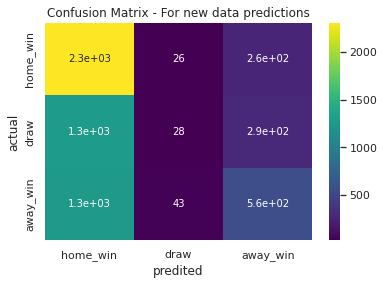

In [17]:
def plot_confusion_matrix(title):
    labels = ['home_win', 'draw', 'away_win']
    confusion_matrix_output = confusion_matrix(y_actual, y_pred, labels=labels)

    fig, ax = plt.subplots()
    sns.heatmap(confusion_matrix_output, annot=True, cmap='viridis', 
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('predited')
    ax.set_ylabel('actual')
    ax.set_title(title);

plot_confusion_matrix('Confusion Matrix - For new data predictions')

## Predictions for Premier League 2023 - Deep Dive

In [19]:
X = transformed_df.query("(season_year == 2023) and (league == 'premier_league')")[features_cols].drop(columns='home_form')
y_actual = transformed_df.query("(season_year == 2023) and (league == 'premier_league')").result

In [24]:
y_pred = model_clf.predict(X)
accuracy_score(y_actual, y_pred)

0.5517241379310345

> **Not too bad for Premier League 2023, 55% accuracy**

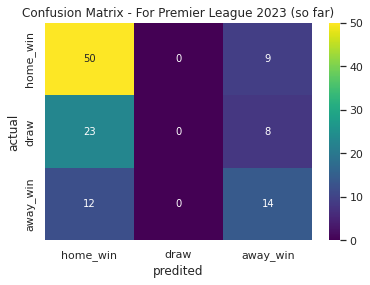

In [25]:
plot_confusion_matrix('Confusion Matrix - For Premier League 2023 (so far)')

No draw predictions though!!

In [52]:
latest_prem_2023 = transformed_df.query("(season_year == 2023) and (league == 'premier_league') and (match_round == 12)")
X_prem_2023_latest = latest_prem_2023[features_cols].drop(columns='home_form')
y_actual_prem_2023_latest = latest_prem_2023.result

y_pred_prem_2023_latest = model_clf.predict(X_prem_2023_latest)

predictions_df = (latest_prem_2023
                    [['home_team', 'away_team', 'score', 'result']]
                    .reset_index()
                    .drop(columns='match_id')
                    .assign(result_prediction=y_pred_prem_2023_latest)
)
predictions_df.style.apply(lambda x: ["background-color: red" if (x.iloc[3] != x.iloc[4]) else "background-color: green" for v in x], axis=1)


,home_team,away_team,score,result,result_prediction
0,Nottingham Forest,Liverpool,1-0,home_win,away_win
1,Everton,Crystal Palace,3-0,home_win,home_win
2,Man. City,Brighton & Hove Albion,3-1,home_win,home_win
3,Chelsea,Man. Utd,1-1,draw,home_win
4,Aston Villa,Brentford,4-0,home_win,home_win
5,Leeds United,Fulham,2-3,away_win,home_win
6,Southampton,Arsenal,1-1,draw,away_win
7,Wolves,Leicester,0-4,away_win,home_win
8,Tottenham Hotspur,Newcastle,1-2,away_win,home_win
9,West Ham,AFC Bournemouth,2-0,home_win,home_win
